Use this link for get the weights
<br>"https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth"

In [11]:
import torch
import torchvision
import sys
path = '/opt/ros/kinetic/lib/python2.7/dist-packages'
if path in sys.path:
    sys.path.remove(path)
import cv2

from PIL import Image
import matplotlib.pyplot as plt
from models import EfficientDet
from torchvision import transforms
import numpy as np
import skimage
from datasets import get_augumentation, VOC_CLASSES
from timeit import default_timer as timer
import argparse
import copy
from utils import vis_bbox, EFFICIENTDET

In [12]:
class args():
    weight = './checkpoint_VOC_efficientdet-d0_268.pth'
    threshold = 0.5
    iou_threshold = 0.6
    score = True
    file_name = 'demo.png'
    num_class = 21
    cam = False

In [13]:
class Detect(object):
    """
        dir_name: Folder or image_file
    """

    def __init__(self, weights, num_class=21, network='efficientdet-d0', size_image=(512,512)): #(512,512)
        super(Detect,  self).__init__()
        self.weights = weights
        self.size_image = size_image
        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() else 'cpu')
        self.transform = get_augumentation(phase='test')
        if(self.weights is not None):
            print('Load pretrained Model')
            checkpoint = torch.load(
                self.weights, map_location=lambda storage, loc: storage)
            params = checkpoint['parser']
            num_class = params.num_class
            network = params.network

        self.model = EfficientDet(num_classes=num_class,
                                  network=network,
                                  W_bifpn=EFFICIENTDET[network]['W_bifpn'],
                                  D_bifpn=EFFICIENTDET[network]['D_bifpn'],
                                  D_class=EFFICIENTDET[network]['D_class'],
                                  is_training=False
                                  )

        if(self.weights is not None):
            state_dict = checkpoint['state_dict']
            self.model.load_state_dict(state_dict)
        if torch.cuda.is_available():
            self.model = self.model.cuda()
        self.model.eval()

    def process(self, threshold, iou_threshold, file_name=None, img=None, show=False):
        if file_name is not None:
            img = cv2.imread(file_name)
        origin_img = copy.deepcopy(img)
        augmentation = self.transform(image=img)
        img = augmentation['image']
        img = img.to(self.device)
        img = img.unsqueeze(0)

        with torch.no_grad():
            scores, classification, transformed_anchors = self.model(img)
            
            # filter by score
            transformed_anchors = transformed_anchors[scores > threshold]
            scores = scores[scores > threshold]
            classification = scores[[scores > threshold]]
            print(transformed_anchors.shape)
            print(transformed_anchors)
            # NMS
            keep_nms = torchvision.ops.nms(transformed_anchors, scores, iou_threshold)
            transformed_anchors = transformed_anchors[keep_nms]
            
            print(transformed_anchors.shape)
            bboxes = list()
            labels = list()
            bbox_scores = list()
            colors = list()
            for j in range(transformed_anchors.shape[0]):
                bbox = transformed_anchors[[j], :][0].data.cpu().numpy()
                x1 = int(bbox[0]*origin_img.shape[1]/self.size_image[1])
                y1 = int(bbox[1]*origin_img.shape[0]/self.size_image[0])
                x2 = int(bbox[2]*origin_img.shape[1]/self.size_image[1])
                y2 = int(bbox[3]*origin_img.shape[0]/self.size_image[0])
                bboxes.append([x1, y1, x2, y2])
                label_name = VOC_CLASSES[int(classification[[j]])]
                labels.append(label_name)

                if(args.cam):
                    cv2.rectangle(origin_img, (x1, y1),
                                  (x2, y2), (179, 255, 179), 2, 1)
                if args.score:
                    score = np.around(
                        scores[[j]].cpu().numpy(), decimals=2) * 100
                    if(args.cam):
                        labelSize, baseLine = cv2.getTextSize('{} {}'.format(
                            label_name, int(score)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
                        cv2.rectangle(
                            origin_img, (x1, y1-labelSize[1]), (x1+labelSize[0], y1+baseLine), (223, 128, 255), cv2.FILLED)
                        cv2.putText(
                            origin_img, '{} {}'.format(label_name, int(score)),
                            (x1, y1), cv2.FONT_HERSHEY_SIMPLEX,
                            0.8, (0, 0, 0), 2
                        )
                    bbox_scores.append(int(score))
                else:
                    if(args.cam):
                        labelSize, baseLine = cv2.getTextSize('{}'.format(
                            label_name), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
                        cv2.rectangle(
                            origin_img, (x1, y1-labelSize[1]), (x1+labelSize[0], y1+baseLine), (0, 102, 255), cv2.FILLED)
                        cv2.putText(
                            origin_img, '{} {}'.format(label_name, int(score)),
                            (x1, y1), cv2.FONT_HERSHEY_SIMPLEX,
                            0.8, (0, 0, 0), 2
                        )
            if show:
                origin_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)
                fig, ax = vis_bbox(img=origin_img, bbox=bboxes,
                                   label=labels, score=bbox_scores)
                fig.savefig('./docs/demo.png')
                plt.show()
            else:
                return origin_img

    def camera(self):
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("Unable to open camera")
            exit(-1)
        count_tfps = 1
        accum_time = 0
        curr_fps = 0
        fps = "FPS: ??"
        prev_time = timer()
        while True:
            res, img = cap.read()
            curr_time = timer()
            exec_time = curr_time - prev_time
            prev_time = curr_time
            accum_time = accum_time + exec_time
            curr_fps = curr_fps + 1

            if accum_time > 1:
                accum_time = accum_time - 1
                fps = curr_fps
                curr_fps = 0
            if res:
                show_image = self.process(img=img)
                cv2.putText(
                    show_image, "FPS: " + str(fps), (10,  20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (204, 51, 51), 2
                )

                cv2.imshow("Detection", show_image)
                k = cv2.waitKey(1)
                if k == 27:
                    break
            else:
                print("Unable to read image")
                exit(-1)
            count_tfps += 1
        cap.release()
        cv2.destroyAllWindows()

Load pretrained Model
Loaded pretrained weights for efficientnet-b0
torch.Size([7, 4])
tensor([[  7.5023, 265.4463,  95.6109, 319.9859],
        [319.5167, 231.5908, 359.8185, 263.8905],
        [124.8094, 248.0977, 195.0235, 294.9008],
        [360.0965, 222.8343, 426.5385, 283.3141],
        [265.1051, 227.2048, 301.4363, 262.6838],
        [232.2429, 237.3415, 254.2911, 263.7623],
        [424.1317, 236.8462, 510.7449, 332.0394]], device='cuda:0')
torch.Size([7, 4])


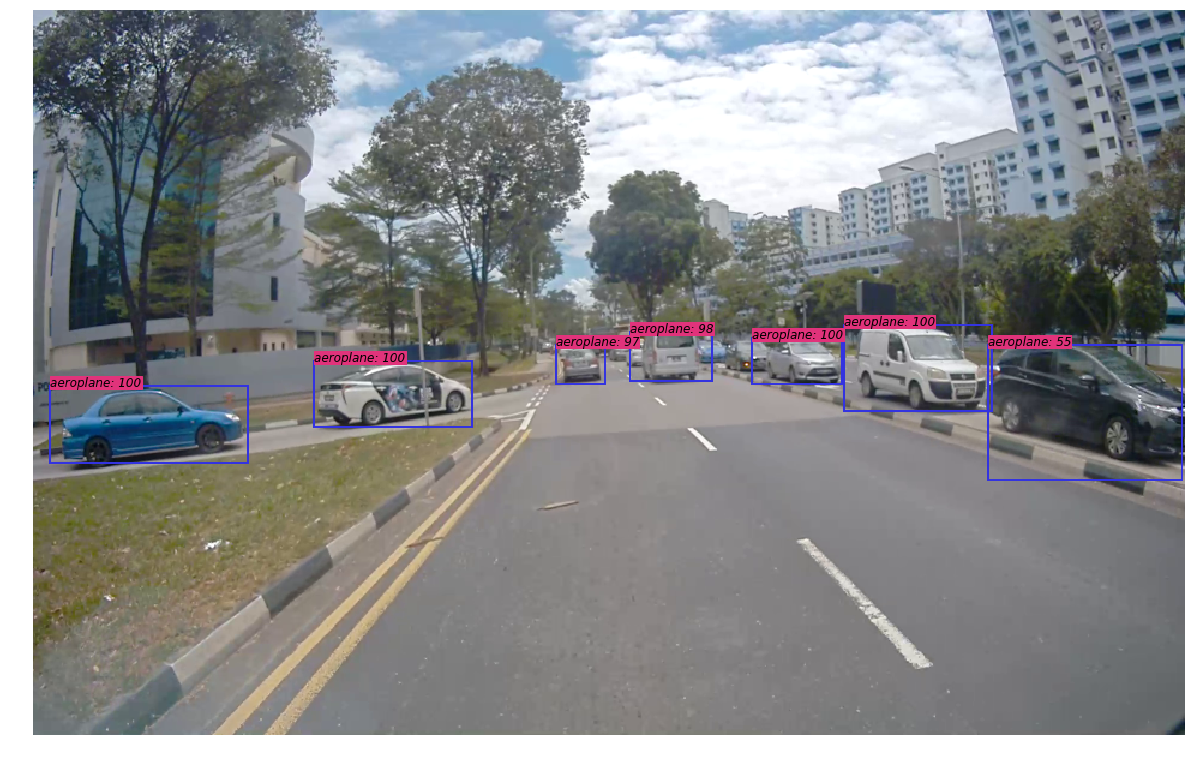

In [14]:
detect = Detect(weights=args.weight)
detect.process(args.threshold, args.iou_threshold, file_name=args.file_name,show=True)

## You can access the model here:

In [19]:
for layer in detect.model.children():
    print(layer)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=